# **Description**
In this notebook you will firstly train a CNN on cifar10 dataset. The CNN architecture is provided in ``` resnet.py ```. Then you are going to immplement targeted and untargeted FGSM attack and also $l_{∞}$-PGD attack, and evaluate the performance of the trained model on the adversarial data.


**Attention!** Make sure you do not miss the questions asked at the end of the notebook.






Name: Mehran Sarmadi

Student ID: 

#**Setups**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#feel free to change the path if needed

%cd /content/drive/MyDrive/HW5 Deep

/content/drive/MyDrive/HW5 Deep


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import matplotlib.pyplot as plt
import numpy as np
from resnet import *


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
'''
These are the default values for variables, these should work, but if needed, you are allowed to change these parameters.
'''

batch_size = 128
lr = 1e-3
epochs = 50

#**Data Preparation (5 pts)**
Use cifar10 dataset provided in torchvision and create train and test dataloaders according to the given transformations.

In [6]:
print('==> Preparing data..')

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


###################################################
#prepare training and test datasets and loaders   #
###################################################


######################
# Your code goes here

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True)

# every batch : [(128, 3, 32, 32) , (128)]

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


#**Building The Model**

In [7]:
########################################
#build your model                      #
########################################
print('==> Building model..')
net = ResNet18()
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)

==> Building model..


#**Training and Evaluating The Model (5 pts)**

In [8]:
# Training
def train(epoch, net, optimizer, trainloader):
    print('\nEpoch: %d' % epoch)
    net.train()
    criterion = nn.CrossEntropyLoss()

    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    return train_loss/len(trainloader), 100*correct/total


def test(epoch, net, testloader):
    net.eval()
    criterion = nn.CrossEntropyLoss()

    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/len(testloader), 100 * correct / total

In [9]:
######################################################################
#train your model, make sure to save loss and accuracy in all epochs #
######################################################################

######################
# Your code goes here

train_loss_lst = []
train_accuracy_lst = []

test_loss_lst = []
test_accuracy_lst = []

for epoch in range(epochs):

    # Train
    train_epoch_loss, train_epoch_accuracy = train(epoch, net, optimizer, trainloader)

    train_loss_lst.append(train_epoch_loss)
    train_accuracy_lst.append(train_epoch_accuracy)

    # Test
    test_epoch_loss, test_epoch_accuracy = test(epoch, net, testloader)

    test_loss_lst.append(test_epoch_loss)
    test_accuracy_lst.append(test_epoch_accuracy)

    print(f"\n  Train Loss: {train_epoch_loss:.2f} and Test  Loss: {test_epoch_loss:.2f}")
    print(f"\n  Train Accuracy: {train_epoch_accuracy:.2f} and   Test  Accuracy: {test_epoch_accuracy:.2f}")




Epoch: 0

  Train Loss: 1.62 and Test  Loss: 1.29

  Train Accuracy: 39.97 and   Test  Accuracy: 52.68

Epoch: 1

  Train Loss: 1.21 and Test  Loss: 1.09

  Train Accuracy: 56.10 and   Test  Accuracy: 60.38

Epoch: 2

  Train Loss: 1.00 and Test  Loss: 0.96

  Train Accuracy: 64.32 and   Test  Accuracy: 66.69

Epoch: 3

  Train Loss: 0.87 and Test  Loss: 0.83

  Train Accuracy: 69.16 and   Test  Accuracy: 71.05

Epoch: 4

  Train Loss: 0.76 and Test  Loss: 0.81

  Train Accuracy: 72.98 and   Test  Accuracy: 71.96

Epoch: 5

  Train Loss: 0.68 and Test  Loss: 0.68

  Train Accuracy: 76.12 and   Test  Accuracy: 76.58

Epoch: 6

  Train Loss: 0.62 and Test  Loss: 0.66

  Train Accuracy: 78.51 and   Test  Accuracy: 77.03

Epoch: 7

  Train Loss: 0.56 and Test  Loss: 0.65

  Train Accuracy: 80.47 and   Test  Accuracy: 78.43

Epoch: 8

  Train Loss: 0.52 and Test  Loss: 0.58

  Train Accuracy: 81.93 and   Test  Accuracy: 80.26

Epoch: 9

  Train Loss: 0.48 and Test  Loss: 0.60

  Train Accu

In [10]:
########################################
#save your model and history           #
########################################

######################
# Your code goes here


path = "/content/drive/MyDrive/HW5 Deep"

# save model
torch.save(net.state_dict(), path + "/model")

# save history
history = {"train_loss": train_loss_lst, "train_accuracy": train_accuracy_lst, "test_loss": test_loss_lst, "test_accuracy": test_accuracy_lst}
torch.save(history, path + "/history.pth")

##**Train and Test Loss and Accuracy Plots**

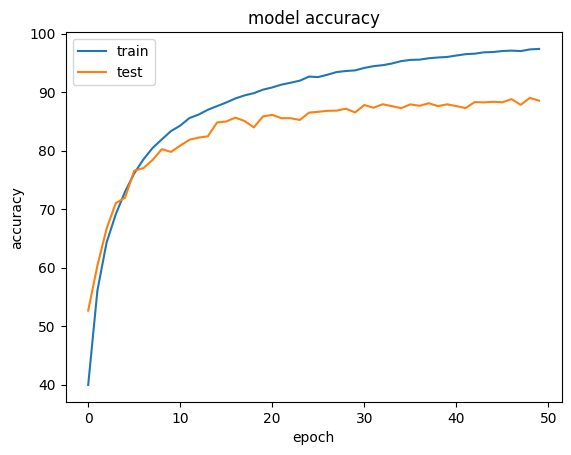

In [11]:
#############################################################
#plot train and test loss and accuracy dusring the training #
#############################################################

######################
# Your code goes here

plt.plot(train_accuracy_lst)
plt.plot(test_accuracy_lst)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

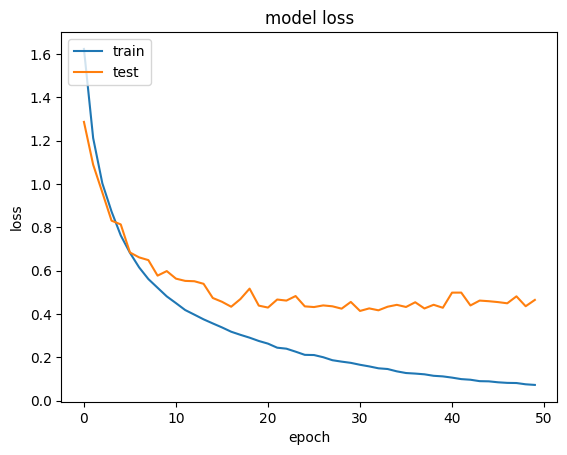

In [12]:
plt.plot(train_loss_lst)
plt.plot(test_loss_lst)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#**FGSM Attack (45 pts)**
In this section you must implement targeted and untargeted FGSM attack and evalute the trained model performance on the adversarial data.[link text](https://)

##**Untargeted FGSM Attack**

In [13]:
########################################
#define untargeted FGSM attack         #
########################################


def FGSM (model, x, y, epsilon):
    """
    inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: clipping threshold/for FGSM

    outputs:
    x': the perturbed image
    delta: the added perturbation
    y': prediction of the model for the perturbed input
    """
    delta = None

    ######################
    # Your code goes here

    x.requires_grad = True

    output = model(x)

    model.zero_grad()

    cost = F.cross_entropy(output, y)

    cost.backward()

    delta = epsilon*x.grad.sign()


    return x+delta, delta, model(x+delta)

###**Evaluation**


 For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [14]:
######################
# Your code goes here
net.eval()
criterion = nn.CrossEntropyLoss()
epsilons = [1/255, 4/255, 8/255]
accuracies = []

for epsilon in epsilons :
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        for idx, input in enumerate(inputs):
            _, _, predicted = FGSM (net, input.unsqueeze(0), targets[idx].unsqueeze(0), epsilon)

        total += 1
        correct += (torch.argmax(predicted) == targets[idx])

    accuracy = 100 * correct / total
    accuracies.append(accuracy.item())

    print(f"for epsilon = {epsilon} test accuracy is equal to {accuracy}")


for epsilon = 0.00392156862745098 test accuracy is equal to 84.81012725830078
for epsilon = 0.01568627450980392 test accuracy is equal to 58.227848052978516
for epsilon = 0.03137254901960784 test accuracy is equal to 26.582279205322266


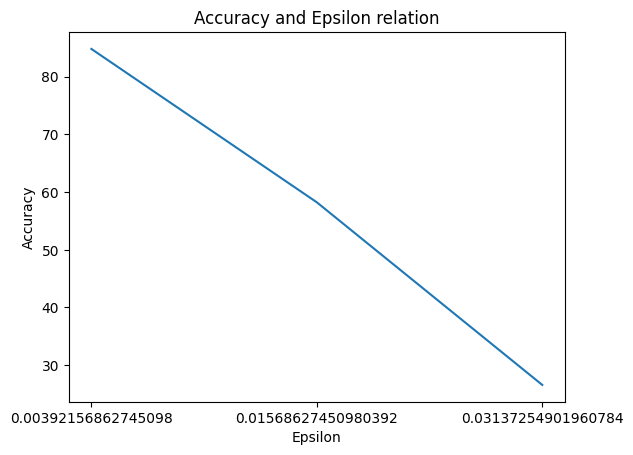

In [15]:
default_x_ticks = range(len(epsilons))
plt.plot(default_x_ticks, accuracies)
plt.xticks(default_x_ticks, epsilons)
plt.title('Accuracy and Epsilon relation')
plt.ylabel('Accuracy')
plt.xlabel('Epsilon')
plt.show()

###**FGSM by gradually increasing $ϵ$**

FGSM attack may not work for small $\epsilon$, on the other hand we want to alter image as insignificant as possible, so here is what we do, we start from $\epsilon = \frac{1}{255}$ and if the attack was unsuccessful, we increase $\epsilon$ by $\frac{1}{255}$. The procedure goes on until the predicted label is different from the ground truth.

In [16]:
#######################################################
#increase epsilon gradually till the label is changed. The function can be implemented recursively.#
#######################################################

def generate_adversarial_FGSM (model, x, label, initial_epsilon=1/255):
    """
    inputs:
    model: model to be attacked
    x: input image
    y: label
    epsilon: intial clipping threshold for FGSM

    outputs:
    epsilon: the epsilon that flips the label.
    delta: the added perturbation
    y': prediction of the model for the perturbed input
    """



    ######################
    # Your code goes here
    k = 1
    _, delta, prediction = FGSM (model, x, label, k*initial_epsilon)

    while torch.argmax(prediction) == label:
        k += 1
        _, delta, prediction = FGSM (model, x, label, k*initial_epsilon)

    return k*initial_epsilon, delta, torch.argmax(prediction)


### **Visualization**
Pick 10 samples from cifar10 test set, each from one class, make sure the selected samples are classified correctly. Plot these samples. Take note that the selected data must not be transformed by train or test transformations while visualisation.

In [17]:
image_list = []



for cls_num in range(10):
    temp = -1
    for images, labels in testloader:
        for idx, label in enumerate(labels):
            if label == cls_num:
                image_list.append(images[idx])
                temp = cls_num
            if cls_num == temp :
                break
        if cls_num == temp :
                break




In [18]:
inverse_transform = transforms.Compose([
    transforms.Normalize(np.zeros(3), 1/np.array([0.2023, 0.1994, 0.2010])),
    transforms.Normalize(-np.array([0.4914, 0.4822, 0.4465]), np.ones(3)),
])

plane


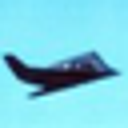

car


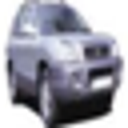

bird


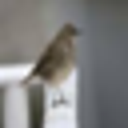

cat


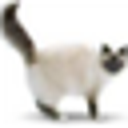

deer


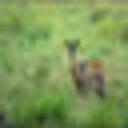

dog


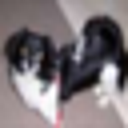

frog


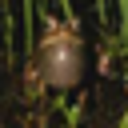

horse


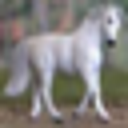

ship


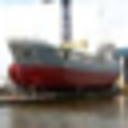

truck


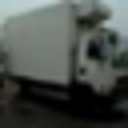

In [19]:
#############################################################################################
#visualize one test sample from each class and make sure that they are correctly labeled.   #
#save index of these samples, since they are needed in the following sections.              #
#############################################################################################


#######################
# Your code goes here


for label, image in enumerate(image_list):

    img = inverse_transform(image)
    pil_image = transforms.ToPILImage()(img).resize((128, 128))

    print(classes[label])
    display(pil_image)




Now, apply untargetted FGSM attack ``` generate_adversarial_FGSM ``` on the selected samples. Visualize the original image, the perturbed image, and the perturbation. since the perturbation is imperceptible, magnify it by the value of $\frac{1}{\epsilon}$ before visualization.

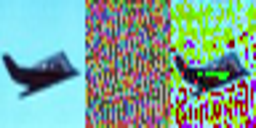

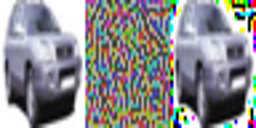

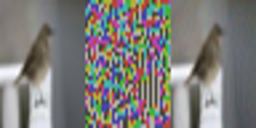

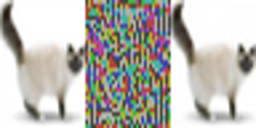

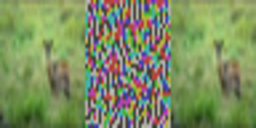

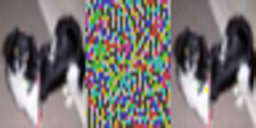

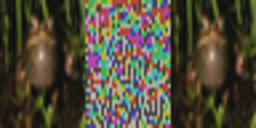

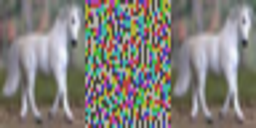

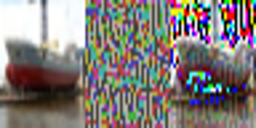

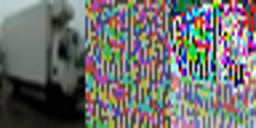

In [20]:
######################################################################################################
#visualize the selected samples, their corresponding perturbed image, and the magnified perturbation #
#also print the ground truth and the predicted label for each sample                                 #
######################################################################################################
for label, image in enumerate(image_list):

    image = image.detach().unsqueeze(0).to(device)
    label = torch.tensor(label).unsqueeze(0).to(device)

    eps, delta, _ = generate_adversarial_FGSM (net, image, label, initial_epsilon=1/255)


    img = torch.empty(3, 32, 96)

    img[:, :, :32] = image
    img[:, :, 32:64] = (1/eps) * delta
    img[:, :, 64:] = image+delta
    img = inverse_transform(img)
    pil_image = transforms.ToPILImage()(img).resize((256, 128))
    display(pil_image)


######################
# Your code goes here


##**Targeted FGSM Attack**
implement targeted FGSM attack.

In [21]:
########################################
#define tergeted FGSM attack           #
########################################

def FGSM_targeted (model, x, y, y_targ, epsilon):
    """
    inputs:
    model: model to be attacked
    x: input image
    y: label
    y_targ = target label
    epsilon: clipping threshold for FGSM

    outputs:
    x': the perturbed image
    delta: the added perturbation
    """

    delta = None

    ######################
    # Your code goes here
    x.requires_grad = True

    output = model(x)

    model.zero_grad()

    cost = F.cross_entropy(output, y_targ)

    cost.backward()

    delta = epsilon*x.grad.sign()


    return x-delta, delta, model(x-delta)



###**Evaluation**
for each sample, select the most probable lable as the target label (if the most probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [22]:
######################
# Your code goes here
net.eval()
criterion = nn.CrossEntropyLoss()
epsilons = [1/255, 4/255, 8/255]
accuracies_mostprobable = []

for epsilon in epsilons :
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        for idx, input in enumerate(inputs):
            target_candidates = torch.topk(net(input.unsqueeze(0)), 2, largest=True, sorted=True)
            if target_candidates.indices[0][0] != labels[idx]:
                target = target_candidates.indices[0][0]
            else :
                target = target_candidates.indices[0][1]

            _, _, predicted = FGSM_targeted (net, input.unsqueeze(0), labels[idx].unsqueeze(0), target.unsqueeze(0), epsilon)

        total += 1
        correct += (torch.argmax(predicted) == labels[idx])

    accuracy = 100 * correct / total
    accuracies_mostprobable.append(accuracy.item())

    print(f"for epsilon = {epsilon} test accuracy is equal to {accuracy}")

for epsilon = 0.00392156862745098 test accuracy is equal to 75.94937133789062
for epsilon = 0.01568627450980392 test accuracy is equal to 62.02531814575195
for epsilon = 0.03137254901960784 test accuracy is equal to 31.645570755004883


for each sample, select the least probable lable as the target label (if the least probable label is the ground truth, select the second most probable label). For $\epsilon \in \{\frac{1}{255}, \frac{4}{255}, \frac{8}{255},\}$ report the performance of the model on targeted FGSM attack on the test data.

In [23]:
######################
# Your code goes here
######################
# Your code goes here
net.eval()
criterion = nn.CrossEntropyLoss()
epsilons = [1/255, 4/255, 8/255]
accuracies_leastprobable = []

for epsilon in epsilons :
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(testloader):
        inputs, labels = inputs.to(device), labels.to(device)
        for idx, input in enumerate(inputs):
            output = net(input.unsqueeze(0))
            target_candidates = torch.topk(output, 2, largest=True, sorted=True)
            least_probable = torch.min(output)
            if least_probable != labels[idx]:
                target = torch.argmin(output)
            else :
                target = target_candidates.indices[0][1].unsqueeze(0)

            _, _, predicted = FGSM_targeted (net, input.unsqueeze(0), labels[idx].unsqueeze(0), target.unsqueeze(0), epsilon)

        total += 1
        correct += (torch.argmax(predicted) == labels[idx])

    accuracy = 100 * correct / total
    accuracies_leastprobable.append(accuracy.item())

    print(f"for epsilon = {epsilon} test accuracy is equal to {accuracy}")


for epsilon = 0.00392156862745098 test accuracy is equal to 82.27848052978516
for epsilon = 0.01568627450980392 test accuracy is equal to 74.68354797363281
for epsilon = 0.03137254901960784 test accuracy is equal to 55.696205139160156


plot accuracy of model with respect to $\epsilon$ both for least probable and most probable target labels (both in a single plot).

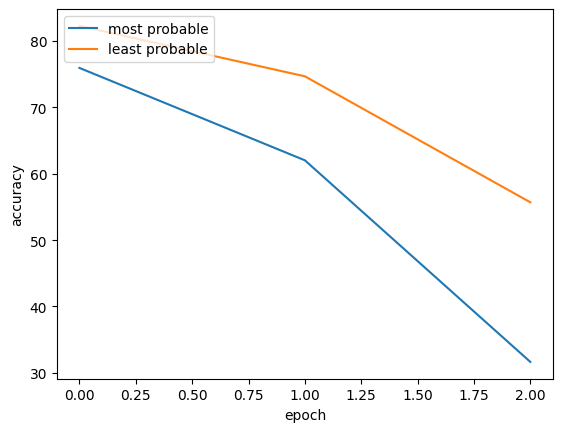

In [24]:
######################
# Your code goes here
plt.plot(accuracies_mostprobable)
plt.plot(accuracies_leastprobable)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['most probable', 'least probable'], loc='upper left')
plt.show()

#**PGD Attack (30 pts)**

Implement PGD attack in the following cell. There is no need to change the default $\epsilon$ and $\alpha$.

In [25]:
def PGD (model, x, y, iterations, epsilon=8/255, alpha=3/255):
  """
  inputs:
    model: model to be attacked
    x: input image
    y: label
    iterations: number of iterations for PGD attack
    epsilon: clipping threshold for PGD
    alpha: step size for PGD attack

  outputs:
    x': the perturbed image
    delta: the added perturbation
    y': prediction of the model for the perturbed input
  """

  delta = None

  ######################
  # Your code goes here

  x_adv = x.detach().clone()

  for it in range(iterations):
    x_adv.requires_grad = True
    model.zero_grad()
    output = model(x_adv)

    cost = F.cross_entropy(output, y)
    cost.backward()

    delta = alpha*x_adv.grad.detach().sign()

    x_adv = x_adv + delta


    x_adv = x + torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
    x_adv = x_adv.detach()

  delta = x - x_adv

  return x+delta, delta, model(x_adv)

##**Evaluation**
for iterations $\in \{3, 7, 12\}$, evaluate performance of the model on adversarial test data.

In [26]:
#####################
# Your code goes here
net.eval()
iterations = [3, 7, 12]
criterion = nn.CrossEntropyLoss()
accuracies_PGD = []
for iteration in iterations:
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        for idx, input in enumerate(inputs):
            _, _, predicted = PGD(net, input.unsqueeze(0), targets[idx].unsqueeze(0), iteration)

        total += 1
        correct += (torch.argmax(predicted) == targets[idx])

    accuracy = 100 * correct / total
    accuracies_PGD.append(accuracy.item())

    print(f"for iteration = {iteration} test accuracy is equal to {accuracy}")


for iteration = 3 test accuracy is equal to 22.78481101989746
for iteration = 7 test accuracy is equal to 20.253164291381836
for iteration = 12 test accuracy is equal to 13.924051284790039


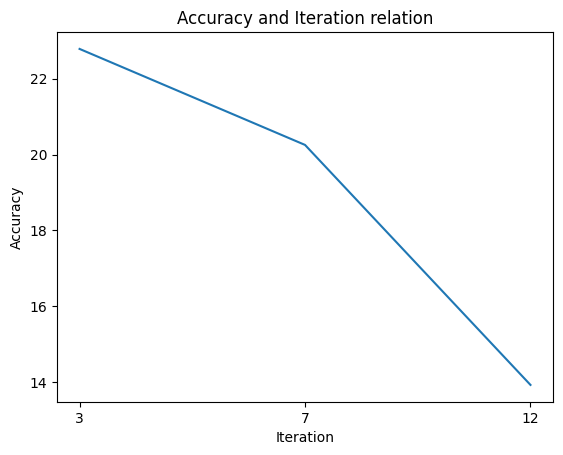

In [27]:
default_x_ticks = range(len(iterations))
plt.plot(default_x_ticks, accuracies_PGD)
plt.xticks(default_x_ticks, iterations)
plt.title('Accuracy and Iteration relation')
plt.ylabel('Accuracy')
plt.xlabel('Iteration')
plt.show()

#**Questions (15 pts)**

1. What was the effect of $\epsilon$ in targeted and untargeted FGSM attack according to your observations?

2. Compare performance of the model on the least probable and most probable targetted FGSM attacks, justify your observation.

3. What was the effect of number of iterations in PGD attack according to your observations?

4. compare the performance of model on PGD attacks and FGSM attacks.

## -----> Answers are in the PDF